# DINOv3 Feature Extraction with Transformers

This notebook demonstrates how to use Facebook's DINOv3 vision transformer model through Hugging Face Transformers for feature extraction and visualization.

## Setup and Installation

Uncomment and run these cells if you need to install dependencies:

In [1]:
# !pip install git+https://github.com/huggingface/transformers
# !pip install accelerate

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from transformers import AutoImageProcessor, AutoModel
from transformers.image_utils import load_image

## Image Loading

Load and display the input image:

In [3]:
image = load_image("images/deer.jpg")
print(f"Loaded image with size: {image.size}")

Loaded image with size: (768, 576)


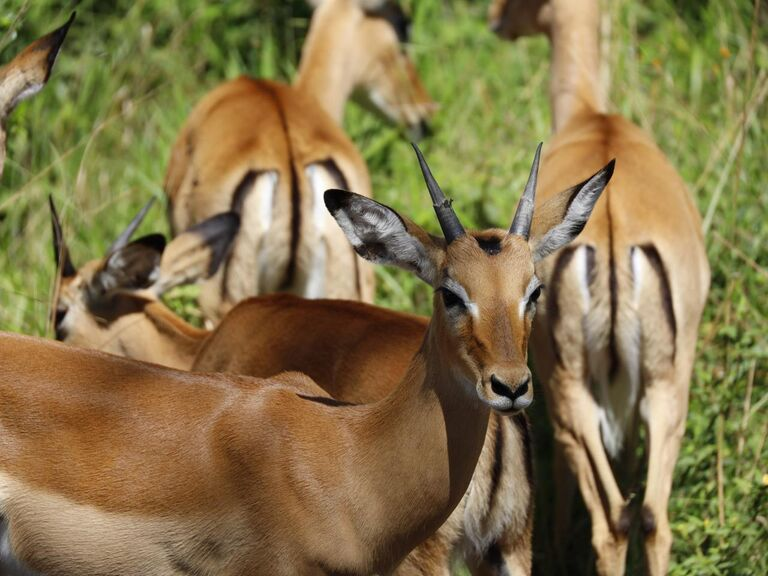

In [4]:
image

## Model Setup

Load the DINOv3 model and processor from Hugging Face:

In [5]:
pretrained_model_name = "facebook/dinov3-vit7b16-pretrain-lvd1689m"

# Setup processor with custom size - no center crop to preserve aspect ratio
processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name, 
    do_center_crop=False, 
    size={"height": 960, "width": 1280}
)

# Load model with automatic device mapping for MPS/CUDA/CPU
model = AutoModel.from_pretrained(
    pretrained_model_name,
    device_map="auto",
)

print(f"Model loaded on device: {model.device}")
print(f"Patch size: {getattr(model.config, 'patch_size', 16)}")

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the disk.


Model loaded on device: mps:0
Patch size: 16


## Image Preprocessing

Process the input image and visualize the preprocessed version:

Processed input shape: torch.Size([1, 3, 960, 1280])


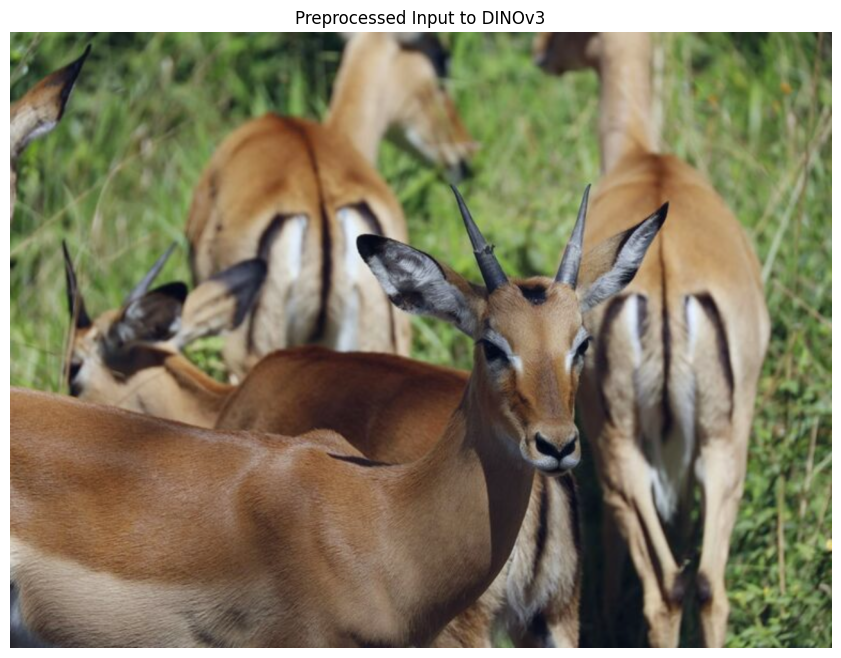

In [6]:
inputs = processor(images=image, return_tensors="pt").to(model.device)
print(f"Processed input shape: {inputs['pixel_values'].shape}")

# Visualize the preprocessed image
input_img = minmax_scale(
    inputs["pixel_values"].cpu()[0].permute(1, 2, 0).numpy().ravel()
).reshape(960, 1280, 3)

plt.figure(figsize=(12, 8))
plt.imshow(input_img)
plt.title("Preprocessed Input to DINOv3")
plt.axis("off")
plt.show()

## Feature Extraction

Extract features using DINOv3 (this will suppress debug outputs):

In [7]:
import logging

# Temporarily suppress transformers logging to reduce debug output
logging.getLogger("transformers").setLevel(logging.ERROR)

with torch.inference_mode():
    outputs = model(**inputs)

# Restore logging level
logging.getLogger("transformers").setLevel(logging.WARNING)

print("Feature extraction completed successfully!")
print(f"Last hidden state shape: {outputs.last_hidden_state.shape}")
print(f"Pooler output shape: {outputs.pooler_output.shape}")

Feature extraction completed successfully!
Last hidden state shape: torch.Size([1, 4805, 4096])
Pooler output shape: torch.Size([1, 4096])


## Feature Analysis

Analyze the extracted features and prepare for visualization:

In [8]:
last_hidden_state = outputs.last_hidden_state  # (B, Ntok, D)
pooler_output = outputs.pooler_output  # (B, D)

# Get input dimensions and patch information
B, C, Hr, Wr = inputs["pixel_values"].shape
P = getattr(model.config, "patch_size", 16)  # ViT-7B/16 => 16
Gh, Gw = Hr // P, Wr // P  # Grid dimensions

print(f"Input shape: {B} × {C} × {Hr} × {Wr}")
print(f"Patch size: {P}")
print(f"Patch grid: {Gh} × {Gw} = {Gh * Gw} patches")
print(f"Total tokens: {last_hidden_state.shape[1]}")

# Calculate special tokens (CLS + register tokens)
T = last_hidden_state.shape[1]
n_special = T - (Gh * Gw)
n_regs = int(getattr(model.config, "num_register_tokens", 0))
has_cls = bool(getattr(model.config, "add_cls_token", True))

print(f"Special tokens: {n_special} (CLS: {has_cls}, registers: {n_regs})")

Input shape: 1 × 3 × 960 × 1280
Patch size: 16
Patch grid: 60 × 80 = 4800 patches
Total tokens: 4805
Special tokens: 5 (CLS: True, registers: 4)


In [9]:
# Extract patch tokens by removing special tokens
patch_tokens = last_hidden_state[:, n_special:, :]  # (B, Gh*Gw, D)
patch_grid = patch_tokens.reshape(B, Gh, Gw, -1)    # (B, Gh, Gw, D)

print(f"Patch tokens shape: {patch_tokens.shape}")
print(f"Patch grid shape: {patch_grid.shape}")
print(f"Feature dimension: {patch_grid.shape[-1]}")

Patch tokens shape: torch.Size([1, 4800, 4096])
Patch grid shape: torch.Size([1, 60, 80, 4096])
Feature dimension: 4096


## Visualization Methods

### 1. Simple Binary Attention Map

Create a binary attention map using PCA to identify salient regions:

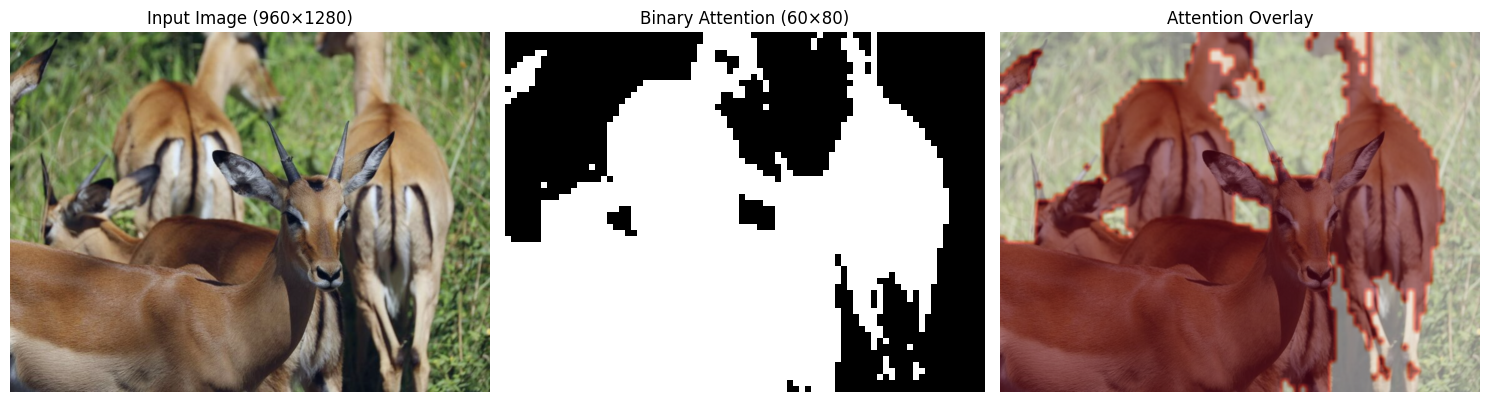

In [10]:
def create_attention_map(patch_grid, threshold=0.5):
    """Create binary attention map using PCA."""
    B, Gh, Gw, D = patch_grid.shape
    X = patch_grid[0].reshape(Gh*Gw, -1).detach().cpu().numpy()
    
    # Use first principal component for attention
    reduced = PCA(1).fit_transform(X)
    norm = minmax_scale(reduced.ravel())
    mask = (norm > threshold).reshape(Gh, Gw).astype(np.uint8)
    
    return mask, norm

# Create attention map
mask_grid, attention_scores = create_attention_map(patch_grid)

# Visualize
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title(f"Input Image ({Hr}×{Wr})")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_grid, cmap="gray")
plt.title(f"Binary Attention ({Gh}×{Gw})")
plt.axis("off")

# Upsample mask for overlay
mask_tensor = torch.from_numpy(mask_grid[None, None, ...].astype(np.float32))
mask_up = F.interpolate(mask_tensor, size=(Hr, Wr), mode="bilinear", align_corners=False)[0,0].numpy()

plt.subplot(1, 3, 3)
plt.imshow(input_img)
plt.imshow(mask_up, alpha=0.5, cmap="Reds")
plt.title("Attention Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

### 2. Dense RGB Feature Visualization

Map high-dimensional features to RGB colors using PCA:

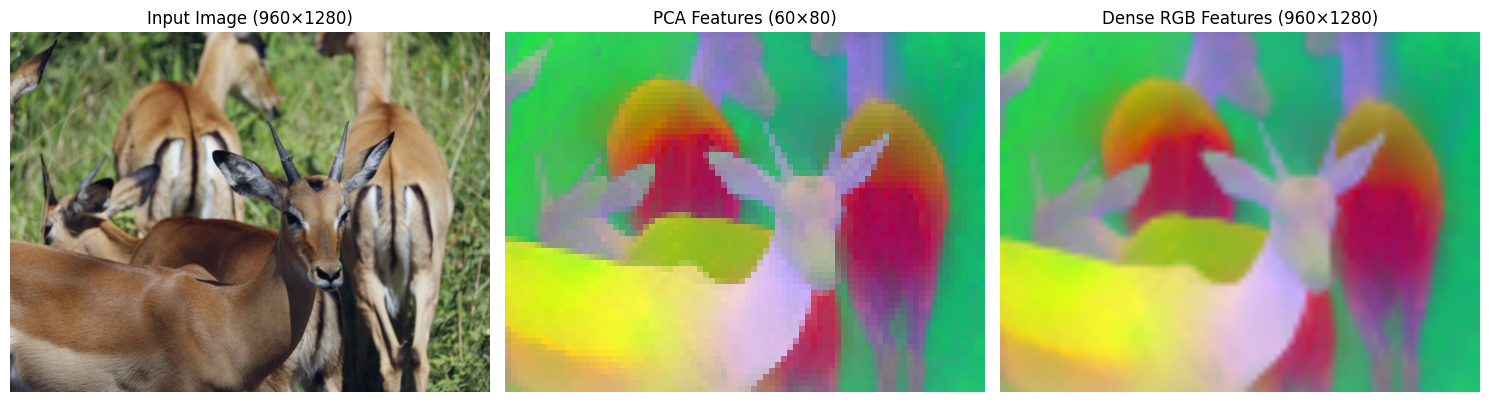

In [11]:
def create_rgb_features(patch_grid, whiten=True):
    """Convert patch features to RGB using PCA."""
    B, Gh, Gw, D = patch_grid.shape
    X = patch_grid[0].reshape(Gh*Gw, -1).detach().cpu().numpy()
    
    # Apply PCA to reduce to 3D (RGB)
    pca = PCA(n_components=3, whiten=whiten)
    feats_pca = pca.fit_transform(X)
    
    # Normalize to [0,1] for RGB
    feats_rgb = minmax_scale(feats_pca, axis=0)
    feats_rgb_grid = feats_rgb.reshape(Gh, Gw, 3)
    
    # Upsample to input resolution
    feats_rgb_tensor = torch.from_numpy(feats_rgb_grid).permute(2, 0, 1)[None, ...]
    feats_rgb_upsampled = F.interpolate(
        feats_rgb_tensor, size=(Hr, Wr), mode='bilinear', align_corners=False
    )[0].permute(1, 2, 0).numpy()
    
    return feats_rgb_grid, feats_rgb_upsampled

# Create RGB feature visualization
rgb_grid, rgb_upsampled = create_rgb_features(patch_grid)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title(f"Input Image ({Hr}×{Wr})")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(rgb_grid)
plt.title(f"PCA Features ({Gh}×{Gw})")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(rgb_upsampled)
plt.title(f"Dense RGB Features ({Hr}×{Wr})")
plt.axis("off")

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrates two complementary approaches to visualizing DINOv3 features:

1. **Binary Attention Maps**: Simple thresholded PCA for identifying salient regions
2. **Dense RGB Feature Visualization**: Direct PCA-to-RGB conversion for comprehensive feature mapping  

Each method reveals different aspects of how DINOv3 processes visual information, from high-level attention patterns to detailed feature representations across the entire image.

### Key Insights:
- DINOv3's patch-based processing creates rich 4096-dimensional feature vectors for each 16×16 pixel patch
- PCA effectively reduces dimensionality while preserving semantic structure and spatial relationships
- Binary attention maps highlight the most distinctive regions using the first principal component
- RGB feature mapping reveals fine-grained feature patterns through three-dimensional color encoding